# Automatic Well-Log Depth Matching with Machine Learning

* __Author__: _Wen Pan, Michael Ashby, Hyungjoo Lee, Lei Fu, Yanxiang Yu, Jaehyuk Lee_
* __Date__: Feburary 18th, 2023

- <a>1. Introduction </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models for Well-Log Prediction</a>
- <a>7. Build DTW-Based Well-Log Alignment Model</a>
- <a>8. Prediction</a>
- <a>9. Discussion</a>
- <a>10. Summary</a>

<a></a>

## Abstract

Well-log preprocessing is important for the accurate interpretation of well logs in the oil and gas industry. Well-log preprocessing usually involves well-log visualization, well-log QC and editing, , depth shifting for well logs and core data, and environment correction. Depth matching is one of the most time-consuming steps in well-log preprocessing that requires a lot of efforts from petrophysicists. Therefore, we see great opportunity for the application of machine learning methods to automate the depth shift process.

Common automatic depth shifting methods include cross-correlation method, dynamic time warping (DTW) method, reinforcement learning, convolutional neural network (CNN)-based method. In this tutorial, we demonstrate a model combining DTW and machine-learning method to perform depth shifting based on a gamma ray (GR) well log. This tutorial aims to provide a starting point for the participants of the 2023 Machine Learning Contest organized by the Society of Petrophysicists and Well Log Analysts (SPWLA) Petrophysical Data-Driven Analytics Special Interest Group (PDDA-SIG). In this tutorial we apply the Random Forest (RF) regression method to sequentially predict misaligned well logs (resistivity (RD), bulk density (RHOB), and neutron porosity (NPHI) logs) based on the reference GR log and aligned well logs. The RF model is trained and validate with well logs from nine aligned wells, and applied on the hidden misaligned well logs from four wells in the same field. DTW is applied to align misaligned well logs to the RF model prediction. The solutions submitted by participants will be ranked based on the rank transformation of the averaged root-mean-squared-error (RMSE) and mean absolute deviation (MAD) between the expert-aligned well logs and shifted well logs in the data set.

## <a>1. Introduction</a>

### <a>1.1. Background</a>
Well-log depth matching is the process of aligning the depths of misaligned well logs to the same reference depth. When logging tools are run in sequence, differences always occur in depth from tool to tool and from run to run. Even when the logging tools are run in a single string there are potential depth differences due to differential cable stretch. Stretch can be pronounced when the logging tool string sticks or temporally hangs up in the hole. All logging measurements must be adjusted to a common depth reference before data processing can continue. A depth shift of length 3 ft can destroy an otherwise good correlation among logging measurements or between well logs and cores.

All depths should be referenced to what is termed a base log. The base log is selected from a logging tool where strong or forceful tool positioning is not used. Free-moving tools travel through the borehole more smoothly than tools that are pushed with great force against the borehole wall, such as the density log. For this reason, strongly centralized tools are not selected as the base log. A resistivity log (induction or laterolog) is usually selected as the base log. For example, if gamma ray logs are available from both the density tool and induction tool strings, it is wise to select the gamma ray from the induction tool as the base log. The gamma ray from the density curve and all curves recorded with the density are then shifted to match the induction log depths. The base curve should also be selected based upon its expected strong correlation with the curves to be depth matched.
Depth-shifting programs are commonly of two types: (a) automatic depth-shifting programs in which mathematical correlations are made among curves from different tool strings and the shifting is accomplished without user input, or (b) visual correlation programs in which the curves to be shifted are laid beside or on top of the base curve, allowing the user to instruct the program by noting correlative points on each log and calculating the depth offset. With older programs, the correlations can be made by using log prints and the shifts input to the screen or a file. Most programs allow the user to carry or cause the same shift to be performed on other curves recorded on the same tool. (https://wiki.aapg.org/Preprocessing_of_logging_data)

### <a>1.2. Problem Statement</a>
The objective of this contest is to develop a data-driven model to shift misaligned well logs to a reference GR log. Well logs of nine wells from the same field that have been depth shifted by a petrophysicist. Participants' models will be trained/validated with these nine wells and tested on misaligned well logs from other three wells from the same field.

The submission should include the shifted well logs and the shifted depths

### <a>1.3. Data Description</a>
#### Files
#### ./data/train/aligned_well_*.csv
Training data for each well. Well logs are aligned by a senior petrophysicist. You need to augment the data in order to train the model. A simple data augmentation method is provided in this tutorial.
Varibles:
- DEPT - Depth, unit in feet
- GR - **Reference Gamma Ray**, unit in API
- RHOB - **Aligned Density Log**, unit in Gram per cubic centimeter
- NPHI - **Aligned Neutron Porosity**, unit in dec
- RD - **Aligned Deep Resistivity**, unit in Ohm.m


#### ./data/test/aligned_well_*.csv
The test data has all features in the train dataset, but they are not aligned (raw), you will need to predict the corrected well logs and associated depth shift.

Predictor Varibles:
- DEPT - Depth, unit in feet
- GR - **Reference Gamma Ray**, unit in API
- RHOB - **Raw Density Log**, unit in Gram per cubic centimeter
- NPHI - **Raw Neutron Porosity**, unit in dec
- RD - **Raw Deep Resistivity**, unit in Ohm.m

Target Variables:
- RHOB_pred - **Corrected Density Log**, unit in Gram per cubic centimeter
- NPHI_pred - **Corrected Neutron Porosity**, unit in dec
- RD_pred - **Corrected Deep Resistivity**, unit in Ohm.m
- RHOB_dept_pred - **Prediction of the Actual Depth of Raw Density Log**, unit in feet
- NPHI_dept_pred - **Prediction of the Actual Depth of Raw Neutron Porosity**, unit in feet
- RD_dept_pred - **Prediction of the Actual Depth of Raw Deep Resistivity**, unit in feet


####  ./data/pdda_submission_1.zip
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
Submissions are evaluated based on normalized mean squared error(NMSE) of corrected well logs and mean absolute deviation (MAD) of depth shift prediction, the final score will be rank transformed and averaged to avoid the scaling of different metrics. 

$$NMSE = \frac{1}{mn}\frac{1}{Var(\mathbf{y})}\sum_{i=1}^{m}\sum_{j=1}^{n}(\hat{\mathbf{y_{i,j}}} - \mathbf{y_{i,j}})^{2}$$

where
- $\hat{y_{i,j}}$ the prediction (RHOB_pred, NPHI_pred, RD_pred) of the **values** for shifted well log j, sample i. $y_{i,j}$ is the actual **values** of the well log j for sample i shifted by a petrophysicist. 
- $m$ is the sample size.
- $n$ is the number of well logs (RHOB, NPHI, RD): 3.
- $Var$ is the variance.

$$MAD = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}|\hat{\mathbf{d_{i,j}}} - \mathbf{d_{i,j}}| $$

where
- $\hat{d_{i,j}}$ is the prediction (RHOB_dept_pred, NPHI_dept_pred, RD_dept_pred) of **depth shift** for raw well log j, sample i. $d_{i,j}$ is the actual **depth shift of raw well logs** by a petrophysicist. 
- $m$ is the sample size.
- $n$ is the number of well logs (RHOB, NPHI, RD): 3.




**Note**:
- Please remember to use random_state for all randomization steps, so the results are reproducible.
- RD is transformed with log10 for RMSE calculation.
- The two scores for your prediction of different well logs will be rank transformed, and averaged, e.g., if the **NMSE** of predictions for the values of RHOB, NPHI, and RD ranks 1st, and the **MAD** of assosiated depth shifts ranks 3rd, your final score would be  $$score = \frac{1+3}{2}=2 $$ The team with the minimum score win the competition
- Understanding and optimizing your predictions for this evaluation metric is paramount for this competition.


**Notes for submission:**
1. Only one user can register for the competition per team. 
2. __The user name has to be exactly the same as the team name__. If space is not allowed, please replace space with underscore '_'.
3. The submission file must be a zip file with three .csv files, which include your predictions of corrected/shfited well logs and their depth shift. **Note: the three csv files in your submission should have the same file names as the three files in the test set**, see name convention below.
- Zipped csv file name {team_name}\_submission\_{number of submission}.zip, which should contain (aligned_well_01.csv, aligned_well_02.csv, and aligned_well_03.csv)
- Each csv file should contain aligned well logs (NPHI_pred,RHOB_pred,RD_pred), which is calculated by shifting raw well logs (NPHI, RHOB, RD) according to reference depth (DEPT) and reference log (GR). The depth of raw well logs after depth shift (NPHI_dept_pred, RHOB_dept_pred,RD_dept_pred) also need to be included in the csv file for MAD calculation. Please refer to submission example "pdda_submission_1.zip" and don't change variable names.
4. The submission status might need a couple minutes to be updated, don't refresh the page too often.
5. The user needs to manually submit their best results to the leaderboard. Click "Participate", " Submit / View Results", click the "+" symbol in your submission. See the red circles in the attached figure.
6. Since Codalab doesn't support two scores or rank transformation, the score you see in the leaderboard is scaled for better display, the first 4 digits represent the scaled NMSE, and the last 4 digits represent the scaled MAD, the final ranking may be different from the leaderboard in Codalab after we collect all submissions. To see the actual scores for depth shift and well-log predictions, please Click "Participate", " Submit / View Results", click the "+" symbol in your submission, and Click "View scoring output log"
7. Please use version-control properly, as we need to validate your code and reproduce the results of the final submitted score in order to rank your team in the final scoreboard.  
8. Max submissions per day: 3
9. Max submissions total: 100
10. Time 03/31/2023-05/26/2023

## <a>2. Imports</a>

In [1]:
# install package for DTW
!pip install dtwalign

In [2]:
# import libraries
import pandas as pd
import numpy as np
import glob
import os
import shutil #used to zip predictions for submission

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

from dtwalign import dtw
from dtwalign import dtw_from_distance_matrix
from scipy.ndimage import gaussian_filter
from scipy import interpolate

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV


np.random.seed(10)

## <a>3. Read Data</a>

In [3]:
files=glob.glob('./data/train/*.csv')
df = []
for i in files:
    df0=pd.read_csv(i)
    df0['well']=i.split('_')[-1].split('.')[0]
    df0['log_RD']=np.log10(df0['RD'])
    df.append(df0.copy())
df_c=pd.concat(df)

## <a>4. Glimps Data</a>

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
for idx,i in enumerate(df):
    print(f"well {i.loc[0,'well']}:")
    display(i.describe())
    display(i.head())

well 01:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,8881.00,8881.00,8881.00,8881.00,8881.00,8881.00
mean,2631.00,113.68,2.49,0.28,7.35,0.80
std,1281.93,27.04,0.08,0.06,19.98,0.18
min,411.00,25.62,1.35,0.06,1.33,0.12
25%,1521.00,96.99,2.46,0.25,5.28,0.72
50%,2631.00,107.59,2.50,0.28,6.51,0.81
75%,3741.00,127.36,2.54,0.31,7.98,0.90
max,4851.00,246.98,2.77,0.67,975.64,2.99


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,411.00,94.01,2.24,0.47,310.51,01,2.49
1,411.50,95.01,2.26,0.48,726.14,01,2.86
2,412.00,96.10,2.28,0.45,975.64,01,2.99
3,412.50,95.68,2.27,0.43,975.64,01,2.99
4,413.00,93.03,2.28,0.41,975.64,01,2.99


well 02:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,7955.00,7955.00,7955.00,7955.00,7955.00,7955.00
mean,2383.50,96.96,2.40,0.31,27.31,0.85
std,1148.28,22.68,0.13,0.07,192.56,0.33
min,395.00,45.85,1.75,0.03,0.35,-0.46
25%,1389.25,82.98,2.35,0.27,5.38,0.73
50%,2383.50,93.29,2.44,0.33,6.87,0.84
75%,3377.75,107.27,2.49,0.35,8.45,0.93
max,4372.00,232.21,2.60,0.46,1957.67,3.29


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,395.00,84.87,2.16,0.39,2.06,02,0.31
1,395.50,84.66,2.09,0.40,3.79,02,0.58
2,396.00,84.67,1.97,0.40,5.04,02,0.70
3,396.50,84.91,1.96,0.41,5.84,02,0.77
4,397.00,85.15,1.95,0.41,6.26,02,0.80


well 03:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,7593.00,7593.00,7593.00,7593.00,7593.00,7593.00
mean,2371.00,109.09,2.50,0.29,7.66,0.80
std,1096.03,25.09,0.07,0.05,26.03,0.21
min,473.00,7.34,1.47,0.04,1.25,0.10
25%,1422.00,96.43,2.47,0.27,4.94,0.69
50%,2371.00,105.25,2.50,0.30,6.99,0.84
75%,3320.00,121.34,2.53,0.32,8.23,0.92
max,4269.00,238.74,2.74,0.61,1292.76,3.11


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,473.00,64.50,2.30,0.33,1065.44,03,3.03
1,473.50,62.98,2.31,0.31,1214.96,03,3.08
2,474.00,62.04,2.31,0.31,1292.76,03,3.11
3,474.50,62.18,2.30,0.31,817.98,03,2.91
4,475.00,64.77,2.29,0.33,417.21,03,2.62


well 04:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,3155.00,3155.00,3155.00,3155.00,3155.00,3155.00
mean,3292.00,114.00,2.50,0.20,7.62,0.79
std,455.46,35.12,0.13,0.05,5.83,0.27
min,2503.50,16.48,2.00,0.07,1.23,0.09
25%,2897.75,94.56,2.46,0.17,3.91,0.59
50%,3292.00,114.73,2.53,0.19,5.75,0.76
75%,3686.25,132.92,2.58,0.23,8.78,0.94
max,4080.50,400.00,3.05,0.46,47.94,1.68


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,2503.50,124.81,2.54,0.26,5.97,04,0.78
1,2504.00,120.11,2.54,0.26,5.95,04,0.77
2,2504.50,117.00,2.54,0.26,6.10,04,0.79
3,2505.00,119.21,2.54,0.25,6.27,04,0.80
4,2505.50,121.56,2.53,0.24,6.32,04,0.80


well 05:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,10345.00,10345.00,10345.00,10345.00,10345.00,10345.00
mean,3067.00,101.85,2.51,0.25,107.66,1.05
std,1493.24,32.81,0.16,0.09,1507.40,0.50
min,481.00,12.06,1.27,0.01,0.21,-0.68
25%,1774.00,88.84,2.46,0.19,6.32,0.80
50%,3067.00,104.16,2.52,0.27,8.36,0.92
75%,4360.00,118.77,2.58,0.31,16.78,1.22
max,5653.00,399.73,2.96,0.65,49851.05,4.70


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,481.00,71.77,2.73,0.36,0.21,05,-0.68
1,481.50,79.11,2.59,0.34,0.27,05,-0.56
2,482.00,87.47,2.50,0.34,0.78,05,-0.11
3,482.50,91.11,2.48,0.36,4.18,05,0.62
4,483.00,92.33,2.47,0.37,10.96,05,1.04


well 06:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,3521.00,3521.00,3521.00,3521.00,3521.00,3521.00
mean,3160.00,117.57,2.49,0.26,8.80,0.83
std,508.28,31.25,0.08,0.05,7.91,0.30
min,2280.00,17.83,2.00,0.09,1.34,0.13
25%,2720.00,101.02,2.45,0.23,4.22,0.63
50%,3160.00,116.86,2.51,0.26,6.25,0.80
75%,3600.00,132.66,2.54,0.29,9.68,0.99
max,4040.00,255.45,2.88,0.50,47.58,1.68


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,2280.00,100.36,2.38,0.30,5.31,06,0.72
1,2280.50,100.03,2.40,0.28,5.03,06,0.70
2,2281.00,99.70,2.47,0.26,4.75,06,0.68
3,2281.50,99.01,2.50,0.25,4.47,06,0.65
4,2282.00,95.78,2.53,0.26,4.20,06,0.62


well 07:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,10346.00,10346.00,10346.00,10346.00,10346.00,10346.00
mean,3156.75,101.51,2.51,0.25,114.33,1.05
std,1493.39,33.01,0.16,0.09,1590.81,0.50
min,570.50,10.99,1.27,0.01,0.31,-0.51
25%,1863.62,88.40,2.47,0.19,6.37,0.80
50%,3156.75,103.58,2.52,0.27,8.49,0.93
75%,4449.88,118.67,2.58,0.31,16.83,1.23
max,5743.00,400.00,2.96,0.66,49485.67,4.69


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,570.50,78.00,2.80,0.40,0.31,07,-0.51
1,571.00,83.80,2.70,0.38,2.12,07,0.33
2,571.50,89.21,2.50,0.37,7.10,07,0.85
3,572.00,93.04,2.48,0.35,7.28,07,0.86
4,572.50,93.40,2.47,0.36,6.17,07,0.79


well 08:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,7284.00,7284.00,7284.00,7284.00,7284.00,7284.00
mean,2370.75,114.12,2.49,0.29,7.99,0.84
std,1051.43,23.59,0.09,0.06,5.87,0.22
min,550.00,38.64,2.00,-0.01,1.36,0.13
25%,1460.38,100.23,2.46,0.26,5.41,0.73
50%,2370.75,110.55,2.51,0.30,7.52,0.88
75%,3281.12,124.81,2.54,0.32,8.82,0.95
max,4191.50,385.83,2.91,0.69,121.38,2.08


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,550.00,92.74,2.49,0.36,7.43,08,0.87
1,550.50,94.72,2.49,0.36,7.12,08,0.85
2,551.00,95.79,2.48,0.37,7.03,08,0.85
3,551.50,94.09,2.48,0.36,7.03,08,0.85
4,552.00,91.99,2.48,0.35,6.83,08,0.83


well 09:


,DEPT,GR,RHOB,NPHI,RD,log_RD
count,10224.00,10224.00,10224.00,10224.00,10224.00,10224.00
mean,3052.75,99.68,2.51,0.25,25.46,0.93
std,1475.78,32.30,0.15,0.09,120.05,0.43
min,497.00,8.43,1.43,0.01,1.03,0.01
25%,1774.88,89.35,2.47,0.18,4.94,0.69
50%,3052.75,103.65,2.52,0.27,6.94,0.84
75%,4330.62,118.19,2.58,0.31,12.07,1.08
max,5608.50,251.97,2.98,0.66,2000.00,3.30


,DEPT,GR,RHOB,NPHI,RD,well,log_RD
0,497.00,82.73,2.45,0.46,1195.41,09,3.08
1,497.50,88.36,2.43,0.43,67.30,09,1.83
2,498.00,88.56,2.40,0.40,2.35,09,0.37
3,498.50,88.76,2.38,0.39,1.90,09,0.28
4,499.00,90.15,2.41,0.39,7.84,09,0.89


## <a>5. Exploratory Data Analysis</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

### Removing the Outliers
You may find that the maximum values of all features are dramatically larger than their mean values, which indicates anomalies and outliers exist in the data set. It's helpful to remove those abnormal data points to improve the performance of the model trained. Here, we used the Isolation Forest algorithm to remove the outliers.

In [5]:
features=['GR','RHOB','NPHI','log_RD','DEPT']
# Remove anomlay
clf = IsolationForest(random_state=0).fit_predict(df_c[features])
dfc_stb = df_c[clf==1]
dfc_stb.describe()

,DEPT,GR,RHOB,NPHI,RD,log_RD
count,59506.00,59506.00,59506.00,59506.00,59506.00,59506.00
mean,2616.82,108.92,2.50,0.27,8.18,0.86
std,1184.32,22.87,0.08,0.06,5.02,0.21
min,424.00,27.26,2.08,0.04,0.35,-0.46
25%,1612.00,95.92,2.46,0.23,5.45,0.74
50%,2651.00,106.06,2.51,0.28,7.15,0.85
75%,3532.50,121.31,2.54,0.31,8.87,0.95
max,5403.00,212.43,2.86,0.43,50.25,1.70


### Bivariate Statistics

Scatter plot and histogram are useful tool for identification of correlation between features and labels. It is suggested to conduct this practice for all the features and gain more insights.

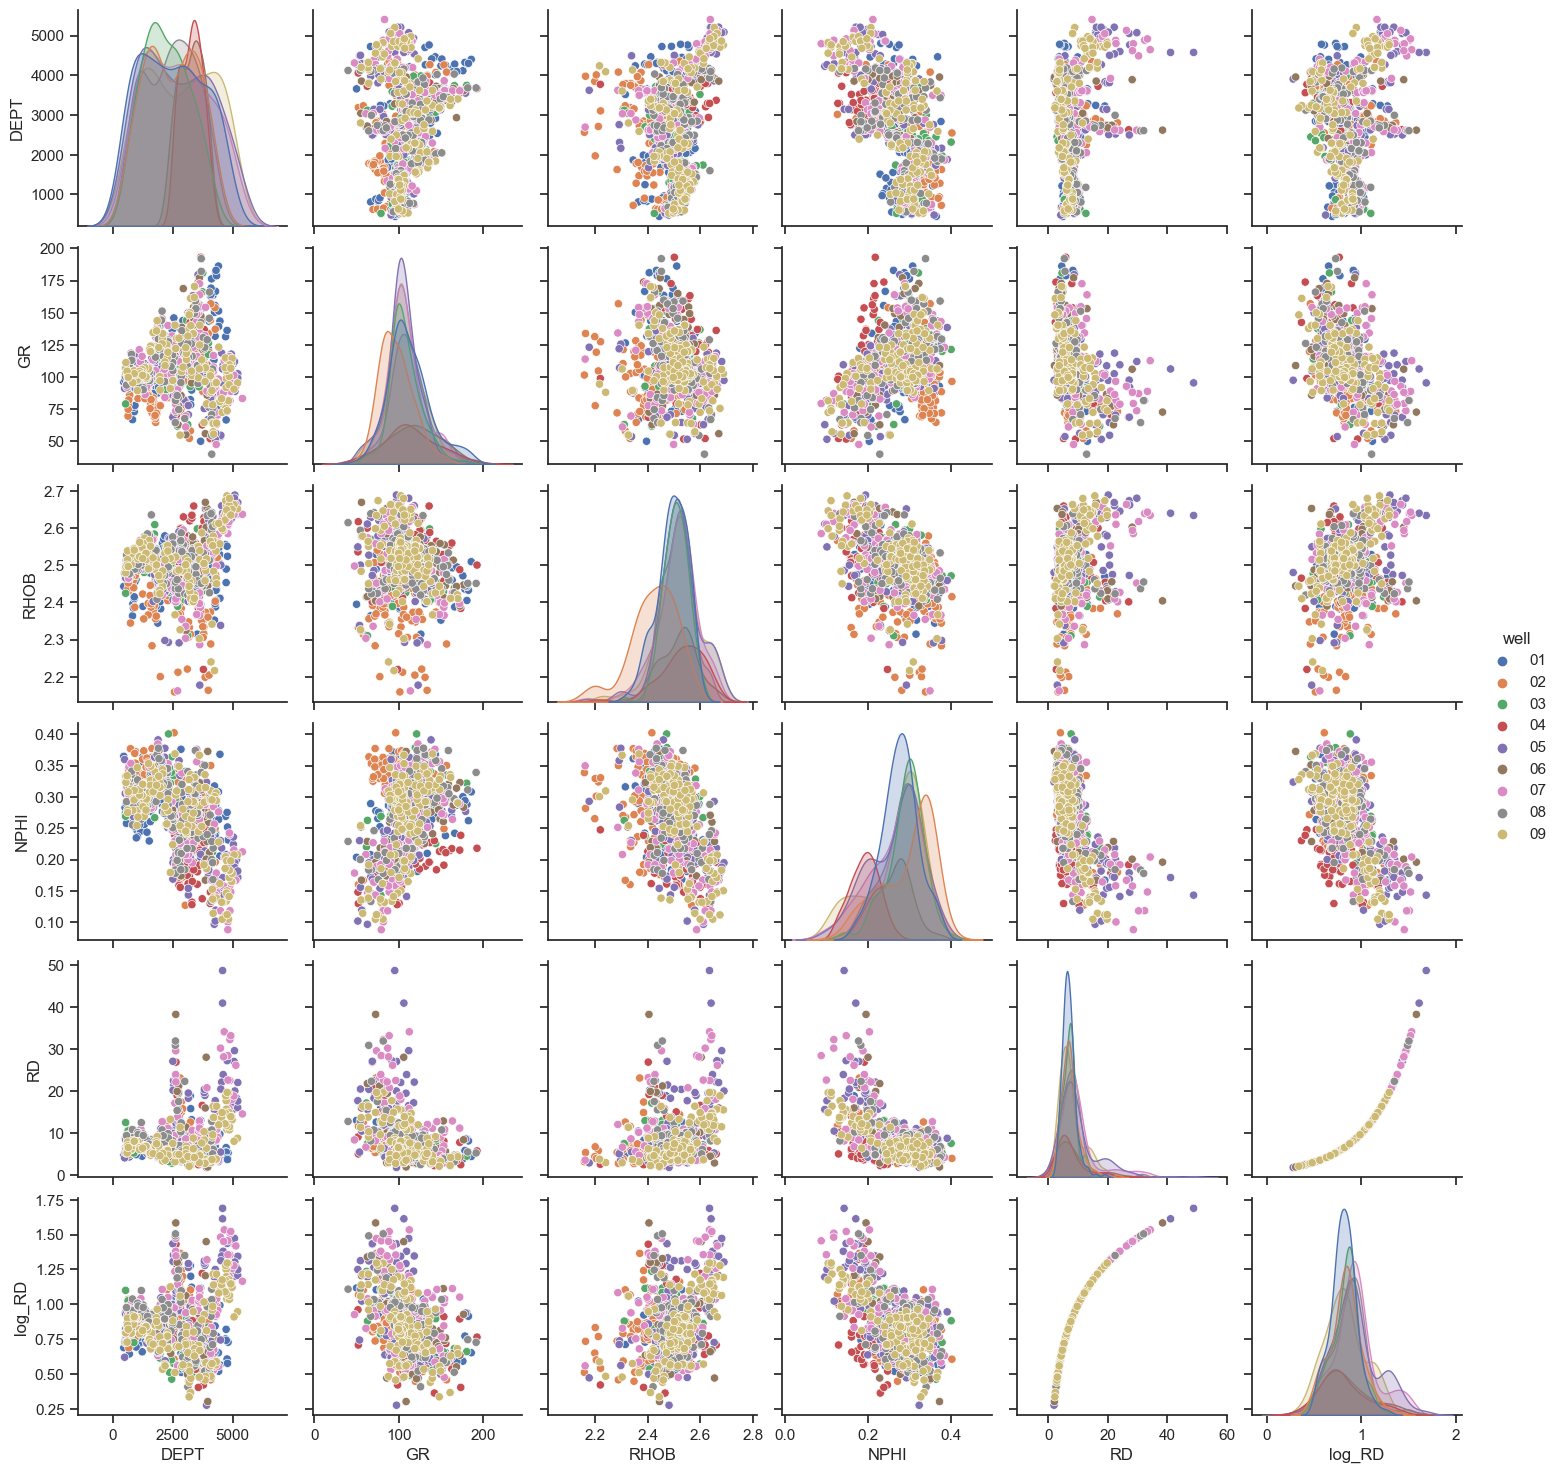

In [6]:
# another library from Seaborn to check the co-linearity
sns.pairplot(dfc_stb.sample(1000).sort_values('well'), hue='well')

## <a>6. Build Machine Models for Well-Log Prediction</a>

### Find Most Predictable Well Log
We will use the base GR log as the input feature for the prediction of "other aligned well logs", which can then be used to align other misaligned well logs.

### Splitting the Data Set Into Training and Testing Data Sets

A standard practice before doing any further data preprocessing and training the supervised learning model is to separate the data into the training and testing data sets, where the testing set can be used to evaluate the generalization of the model in terms of overfitting or underfitting. Once the train-test split is performed, the test data set should not be touched to avoid information leakage from the testing data set to the training data set. The testing data set should be used only for purposes of evaluating the generalization capability of the model. In the code shown below, we used the 70% of wells for training and the rest 30% well for validation purposes. The participants may apply different strategies to separate the training data set and testing set.

In [7]:
# Here, we separate train and validation data by wells
wells=dfc_stb['well'].unique()
np.random.shuffle(wells)
split=0.7
n=int(np.round(len(wells)*split))
train_well,val_well=dfc_stb[dfc_stb['well'].isin(wells[:n])].copy(),dfc_stb[dfc_stb['well'].isin(wells[n:])].copy()
# # if you want to separate train and test data randomly
# # please remember to use random_state for all randomization steps, this will ensure we get the same results 
# # as yours during the validation phase. 
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

In [8]:
def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_

### Training & Validation
After training on the X_train and y_train, the Random Forest regression model was then evaluated on the training data set. Here we use RMSE, but you may want to use NMSE to perform sequential prediction

In [9]:
Y_feat=['RHOB','NPHI','log_RD']

In [10]:
x_feat=['GR','DEPT']
y_feat=['RHOB','NPHI','log_RD']
score=[]
for feat in y_feat:
    # Random forest model
    RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    RF_best = grid_search(RF, {}, X_train=train_well[x_feat].values, y_train=train_well[feat].values)
    y_pred=RF_best.predict(val_well[x_feat].values)
    score.append(np.sqrt(np.mean((y_pred-val_well[feat])**2))/val_well[feat].std())
    print(f"RMSE {feat}:{score[-1]}")

RMSE RHOB:1.0447403628692273
RMSE NPHI:0.7915163375214437
RMSE log_RD:1.0460031714531175


NPHI has the lowest RMS, so it will be aligned first

In [11]:
x_feat1=['GR','DEPT']
y_feat1=['NPHI']
score=[]
for feat in y_feat1:
    # Random forest model
    RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    RF_best_1 = grid_search(RF, {}, X_train=train_well[x_feat1].values, y_train=train_well[feat].values)
    feat_name=feat+'_pred'
    val_well[feat_name]=RF_best_1.predict(val_well[x_feat1].values)

Compare RHOB and log_RD

In [12]:
x_feat=['GR','DEPT','NPHI']
y_feat=['RHOB','log_RD']
score=[]
for feat in y_feat:
    # Random forest model
    RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    RF_best = grid_search(RF, {}, X_train=train_well[x_feat].values, y_train=train_well[feat].values)
    y_pred=RF_best.predict(val_well[x_feat].values)
    score.append(np.sqrt(np.mean((y_pred-val_well[feat])**2))/val_well[feat].std())
    print(f"RMSE {feat}:{score[-1]}")

RMSE RHOB:0.8616960644097428
RMSE log_RD:0.8636951148351335


RHOB has the lowest RMS, so it will be aligned second

In [13]:
x_feat2=['GR','DEPT','NPHI']
y_feat2=['RHOB']
score=[]
for feat in y_feat2:
    # Random forest model
    RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    RF_best_2 = grid_search(RF, {}, X_train=train_well[x_feat2].values, y_train=train_well[feat].values)
    feat_name=y_feat2[0]+'_pred'
    val_well[feat_name]=RF_best_2.predict(val_well[x_feat2].values)

LogRD is predicted last

In [14]:
x_feat3=['GR','DEPT','NPHI','RHOB']
y_feat3=['log_RD']
score=[]
for feat in y_feat3:
    # Random forest model
    RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
    RF_best_3 = grid_search(RF, {}, X_train=train_well[x_feat3].values, y_train=train_well[feat].values)
    y_pred=RF_best_3.predict(val_well[x_feat3].values)
    score.append(np.sqrt(np.mean((y_pred-val_well[feat])**2))/val_well[feat].std())
    print(f"RMSE {feat}:{score[-1]}")    
    feat_name=y_feat3[0]+'_pred'
    val_well[feat_name]=RF_best_3.predict(val_well[x_feat3].values)
    

RMSE log_RD:0.8602414386332561


### Visualization
The Random Forest regressor is then applied to the validation data set.

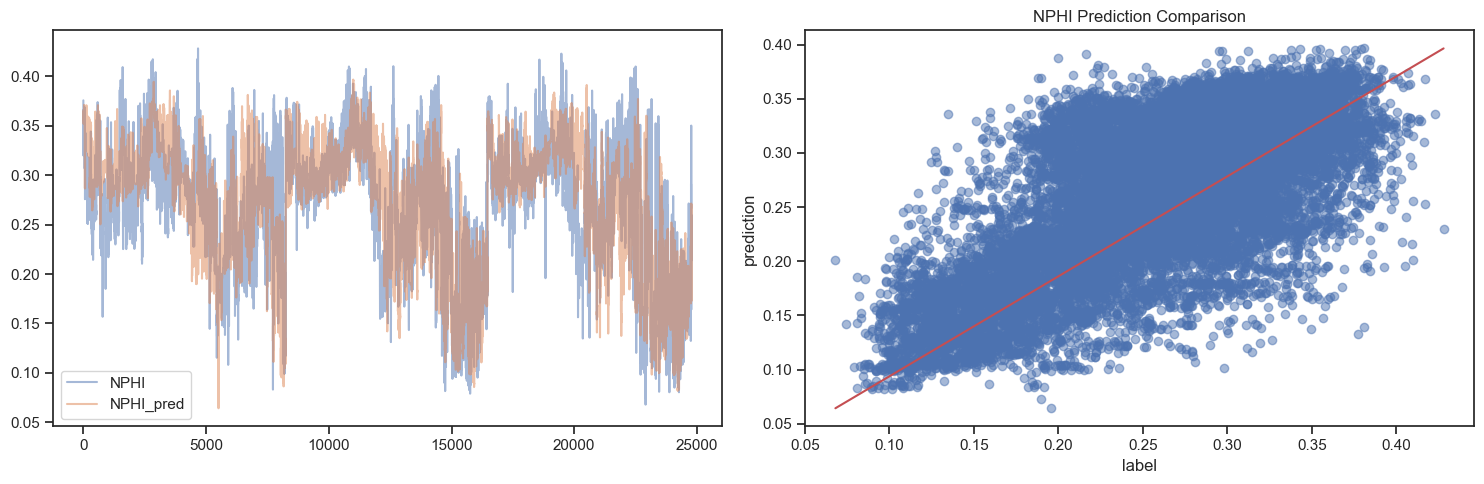

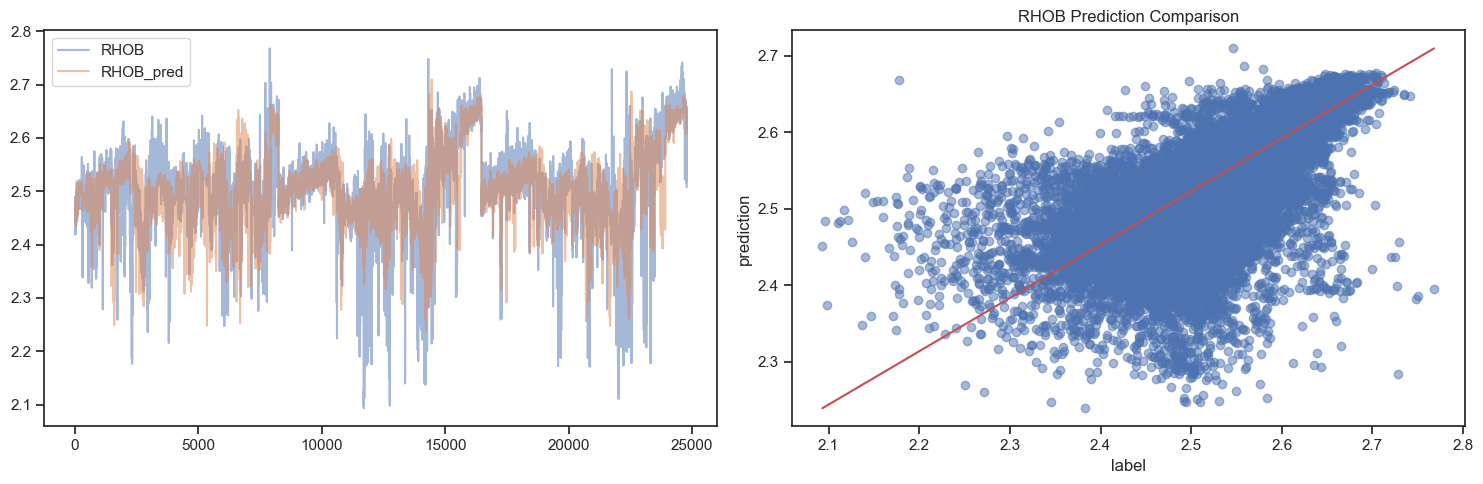

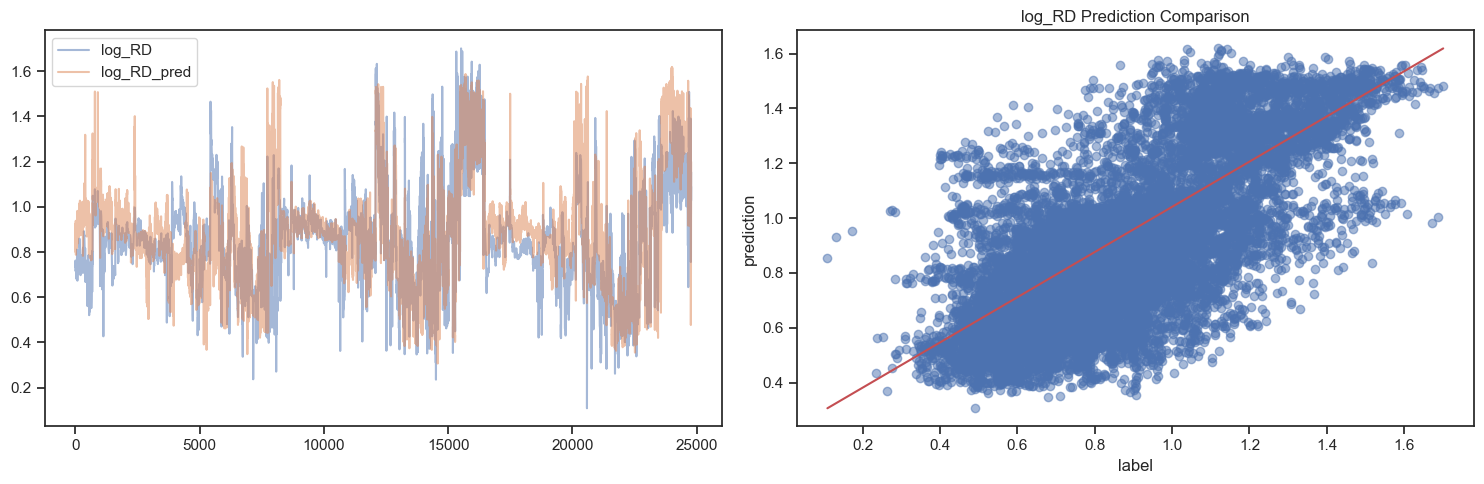

In [15]:
for feat in ['NPHI','RHOB','log_RD']:
    fig, axs = plt.subplots(1,2,figsize=(15, 5))
    axs[0].plot(val_well[feat].values,label=feat,alpha=0.5)
    axs[0].plot(val_well[feat+'_pred'].values,label=feat+'_pred',alpha=0.5)
    axs[0].legend()
    plt.xlabel('sample')
    plt.ylabel('value')
    plt.title(f'{feat} Prediction Comparison')
    axs[1].scatter(val_well[feat].values, val_well[feat+'_pred'].values,alpha=0.5)
    axs[1].plot([np.min(val_well[feat].values), np.max(val_well[feat].values)], [np.min(val_well[feat+'_pred'].values), np.max(val_well[feat+'_pred'].values)], color='r')
    plt.xlabel('label')
    plt.ylabel('prediction')
    plt.title(f'{feat} Prediction Comparison')
    plt.tight_layout()

## <a>7. Build DTW-Based Well-Log Alignment model for Validation Data Set</a>

DTW is a dynamic programming method that commonly used for signal alignment. By default it minimizes the MSE between the reference signal and query signal.

The method below is a simple depth perturbation method for data augmentation. It can be used to train a supervised alignment algorithm, such as RL-based depth shift agent, or screen unsupervised methods.

In [16]:
def random_stretch(curve,depth0,ank_p=0.4):

    length=curve.shape[0]
    assert depth0.shape[0]==curve.shape[0], "depth and curve do not match!"
    depth=depth0.copy()
    # find location after perturbation
    n=int(length*ank_p)
    np.random.seed()
    anchor_points0=np.sort(np.random.choice(np.arange(0,length),n,replace=False))
    anchor_points1=np.sort(np.random.choice(np.arange(0,length),n,replace=False))

    depth1=np.interp(depth,depth[anchor_points0],depth[anchor_points1],left=-99999,right=99999)
    good=(-99999<depth1)*(depth1<99999)
    depth1[depth1==99999]=depth1[good][-1]-depth[good][-1]+depth[depth1==99999]
    depth1[depth1==-99999]=depth1[good][0]-depth[good][0]+depth[depth1==-99999]
    f=interpolate.interp1d(depth1,curve,fill_value=(curve[0], curve[-1]), bounds_error=False,kind=1)
    new_curve=f(depth0)+np.random.normal(0,0.0001,curve.shape) # values of perturbed log
    new_depth=np.interp(depth0, depth1, depth0,left=depth0[0],right=depth0[-1]) #truth depth of perturbed log
    return new_curve,new_depth  

In [17]:
for i in Y_feat:
    val_well[i+'_raw']=np.nan
    val_well[i+'_dept']=np.nan
for i in val_well['well'].unique():
    idx=val_well['well']==i
    for j in Y_feat:
        val_well.loc[idx,j+'_raw'],val_well.loc[idx,j+'_dept']=random_stretch(val_well.loc[idx,j].values,val_well.loc[idx,'DEPT'].values)
    

In [18]:
val_well

,DEPT,GR,RHOB,NPHI,RD,well,log_RD,NPHI_pred,RHOB_pred,log_RD_pred,RHOB_raw,RHOB_dept,NPHI_raw,NPHI_dept,log_RD_raw,log_RD_dept
26,424.00,96.07,2.49,0.38,5.42,01,0.73,0.36,2.47,0.84,2.49,424.00,0.38,424.00,0.74,424.50
27,424.50,97.29,2.48,0.36,5.44,01,0.74,0.36,2.47,0.83,2.48,425.25,0.38,424.00,0.74,425.25
28,425.00,97.60,2.48,0.34,5.47,01,0.74,0.36,2.45,0.89,2.47,426.50,0.38,424.00,0.74,426.00
29,425.50,97.23,2.48,0.32,5.49,01,0.74,0.36,2.47,0.93,2.44,436.00,0.38,424.00,0.75,427.50
30,426.00,96.91,2.48,0.33,5.53,01,0.74,0.36,2.45,0.92,2.42,438.00,0.38,424.00,0.76,429.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9682,5338.00,86.49,2.65,0.21,10.66,09,1.03,0.18,2.65,1.17,2.65,5329.00,0.22,5337.61,1.01,5334.33
9683,5338.50,90.05,2.61,0.25,11.64,09,1.07,0.17,2.65,1.06,2.55,5330.00,0.22,5338.06,1.02,5334.39
9684,5339.00,91.24,2.56,0.26,12.72,09,1.10,0.18,2.65,1.02,2.53,5330.75,0.25,5338.50,1.02,5334.44
9685,5339.50,89.47,2.53,0.23,13.73,09,1.14,0.17,2.65,1.07,2.52,5331.50,0.16,5340.00,1.03,5334.50


### Perform alignment for each well assuming we know the truth logs

In [19]:
dfs_val = dict(tuple(val_well.groupby('well')))

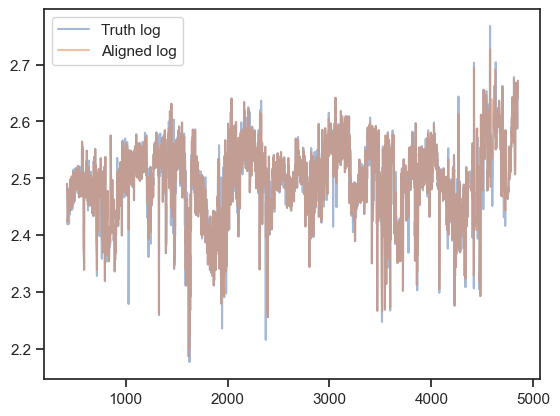

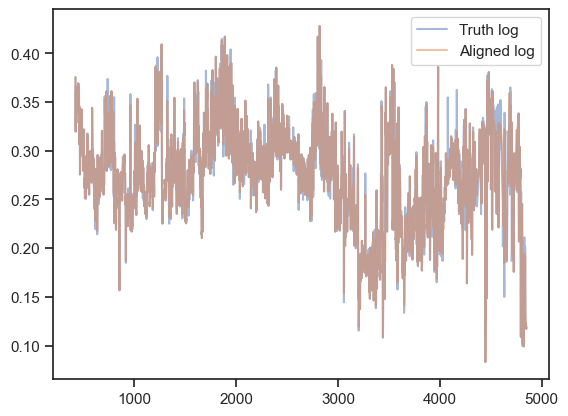

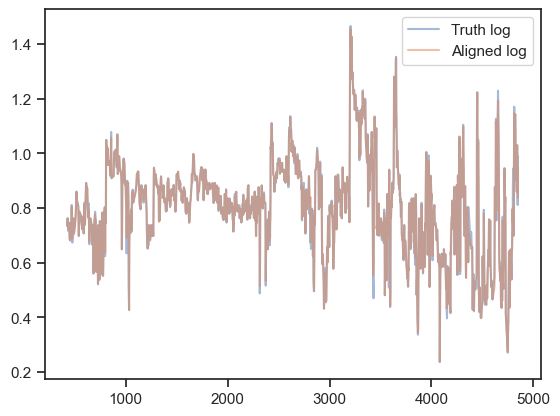

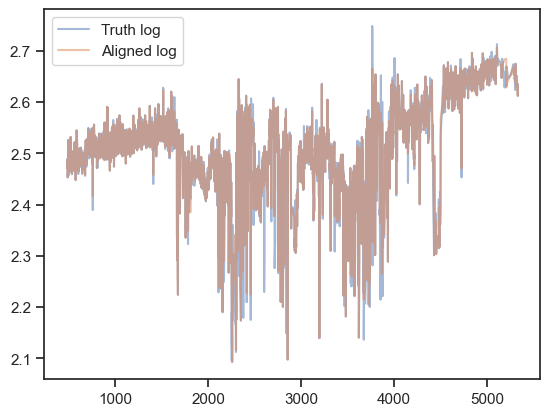

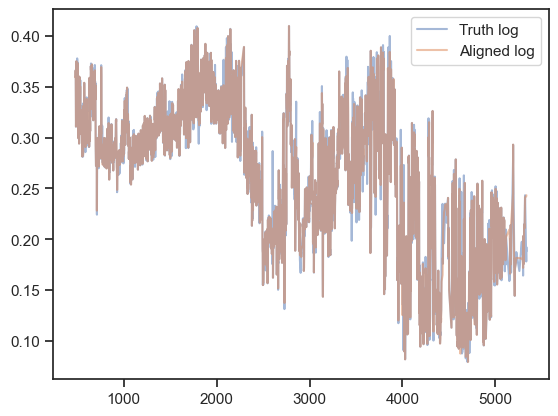

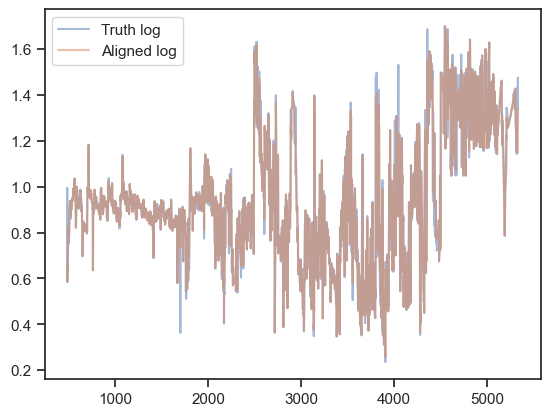

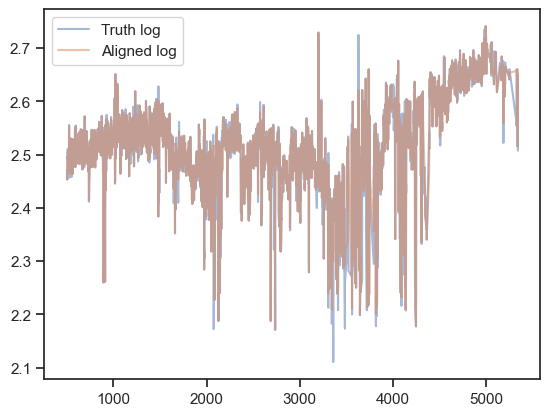

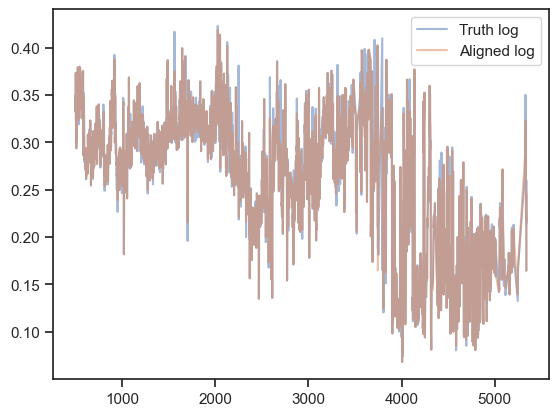

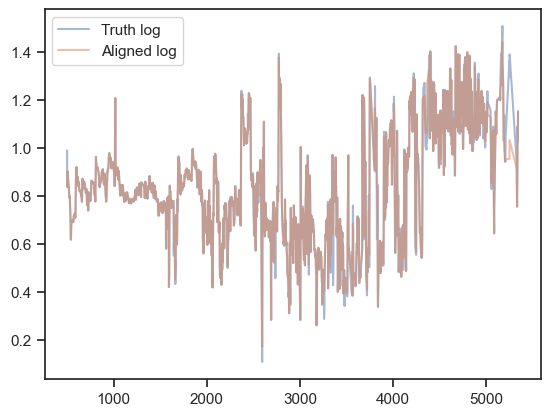

In [20]:

N=101
for well in list(dfs_val.keys()):
    for mykey in Y_feat:
        ref=dfs_val[well][f'{mykey}'].values
        query=dfs_val[well][f'{mykey}_raw'].values

        ref_mean=np.convolve(ref, np.ones(N)/N, mode='same')
        query_mean=np.convolve(query, np.ones(N)/N, mode='same')

        ref2_mean=np.convolve((ref-ref_mean)**2, np.ones(N)/N, mode='same')
        query2_mean=np.convolve((query-query_mean)**2, np.ones(N)/N, mode='same')    

        ref_norm=(ref-ref_mean)/ref2_mean
        query_norm=(query-query_mean)/query2_mean


        query=(query-query.mean())/query.std()*ref.std()+ref.mean()
    #     loss_matrix=(query.reshape(1,-1)-ref.reshape(-1,1))**2
        alignmentOBE = dtw(query,ref,
                             step_pattern="asymmetric",# dist=lambda x, y: 10000000-x*y,
                             window_type="sakoechiba", window_size=201)
        mypath=alignmentOBE.get_warping_path(target="reference")
        dfs_val[well][f'{mykey}_dept_pred']=dfs_val[well]['DEPT'].values[mypath]
        
        f=interpolate.interp1d(dfs_val[well]['DEPT'].values[mypath]+0.0000001*np.arange(dfs_val[well]['DEPT'].values.size),dfs_val[well][f'{mykey}_raw'].values,
                               fill_value=(dfs_val[well][f'{mykey}_raw'].values[0], dfs_val[well][f'{mykey}_raw'].values[-1]), 
                               bounds_error=False,kind=1)
        dfs_val[well][f'{mykey}_val_pred']=f(dfs_val[well]['DEPT'].values)

        
        
        plt.figure()
        plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}'].values,alpha=0.5,label='Truth log')
#         plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}_pred'].values,alpha=0.5,label='Predict log')
        plt.plot(dfs_val[well][f'{mykey}_dept_pred'].values,dfs_val[well][f'{mykey}_raw'].values,alpha=0.5,label='Aligned log')
#         plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}_val_pred'],alpha=0.5,label='Aligned log')
#         plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}_val_pred'],alpha=0.5,label='Aligned log')
        plt.legend()
        plt.show()

### Evaluate the performance of this alignment algorithm

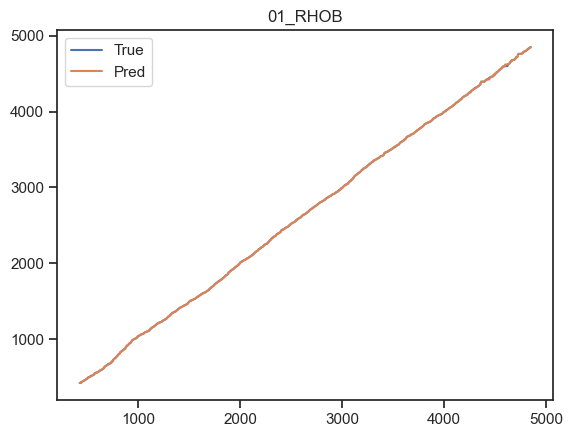

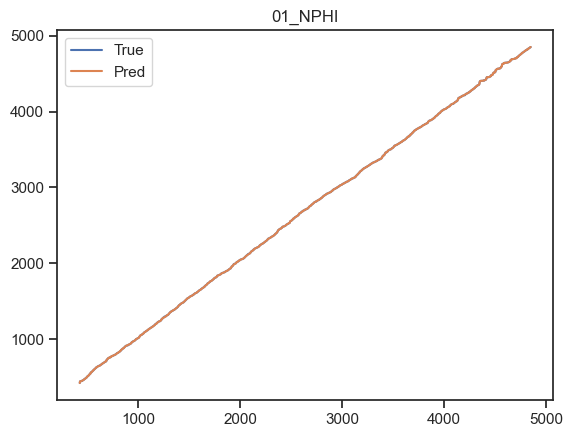

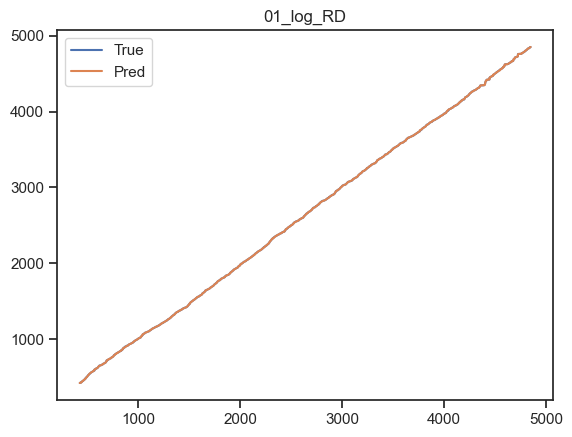

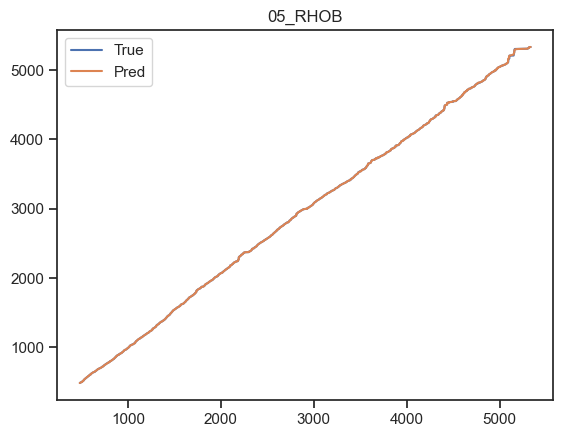

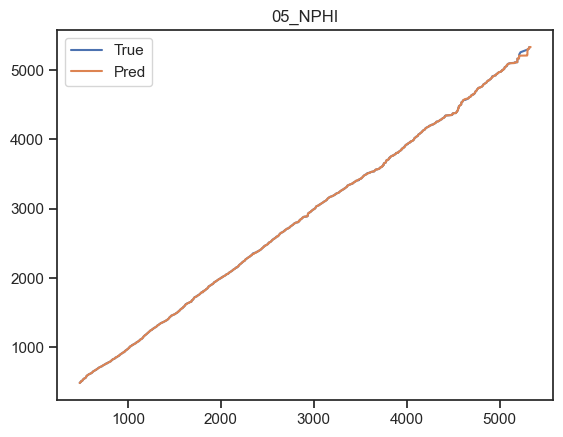

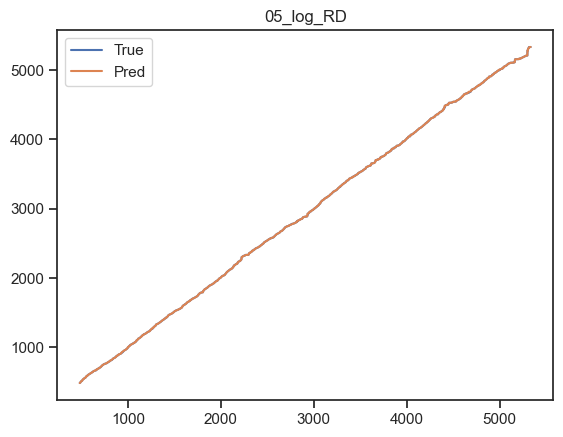

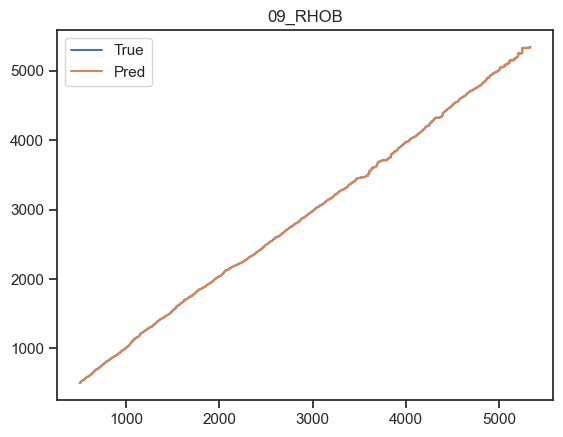

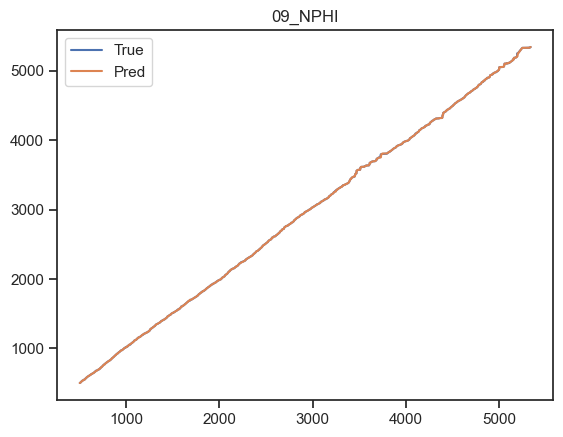

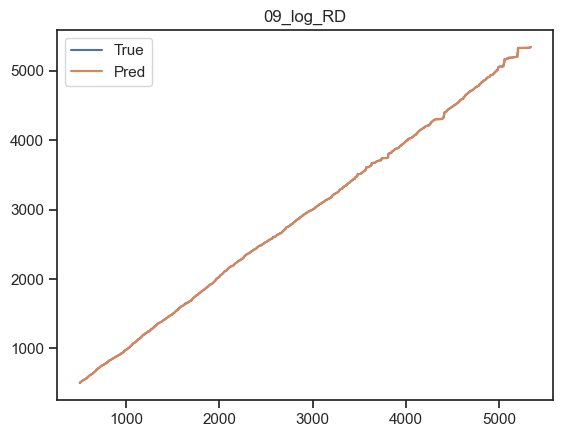

In [21]:
for well in list(dfs_val.keys()):
    for mykey in Y_feat:
        plt.figure()
        plt.plot(dfs_val[well][f'{mykey}_dept'].values,dfs_val[well]['DEPT'].values,label='True')
        plt.plot(dfs_val[well][f'{mykey}_dept_pred'],dfs_val[well]['DEPT'].values,label='Pred')
        plt.title(f'{well}_{mykey}')
        plt.legend()
        plt.show()


### Perform alignment for each well assuming we don't know the truth logs

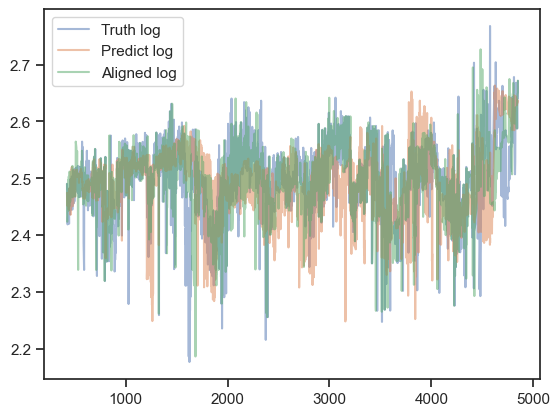

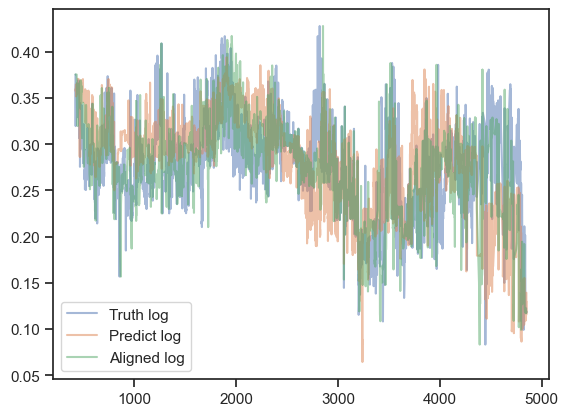

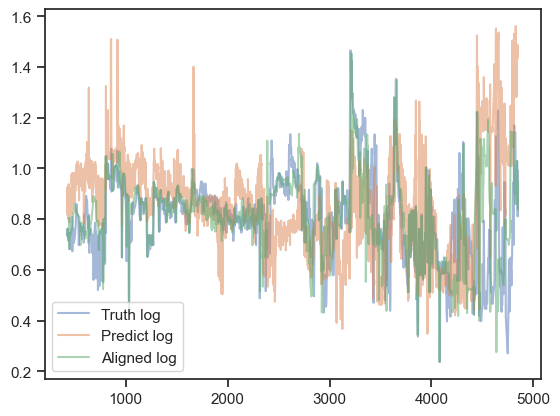

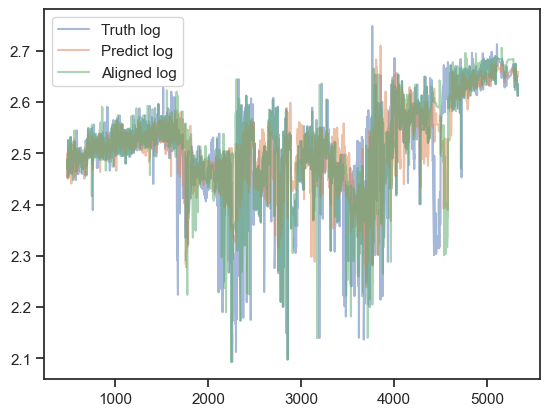

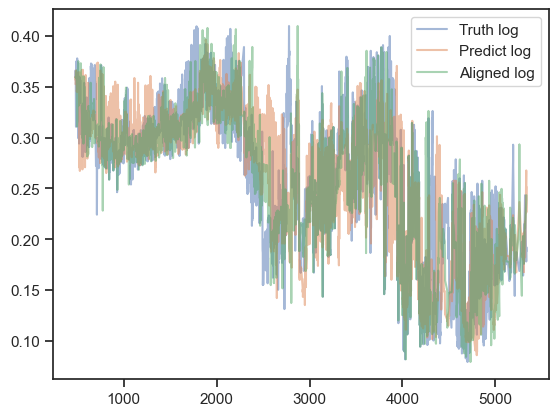

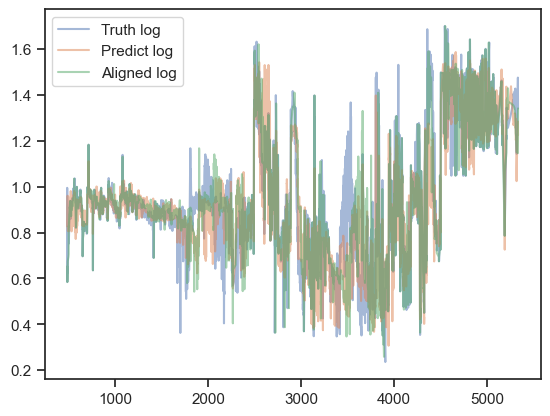

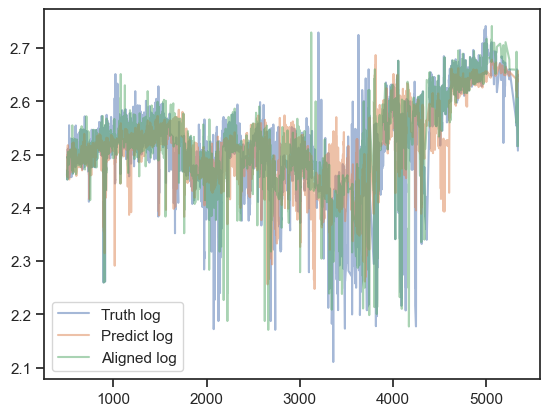

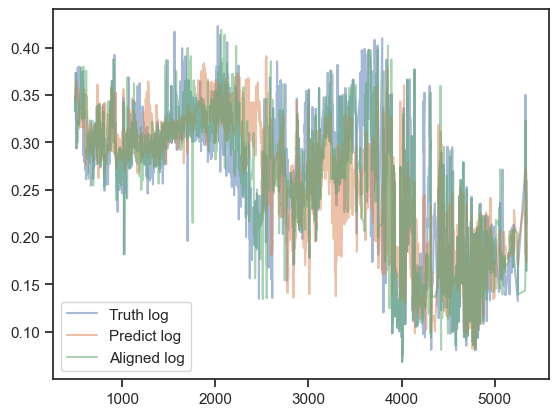

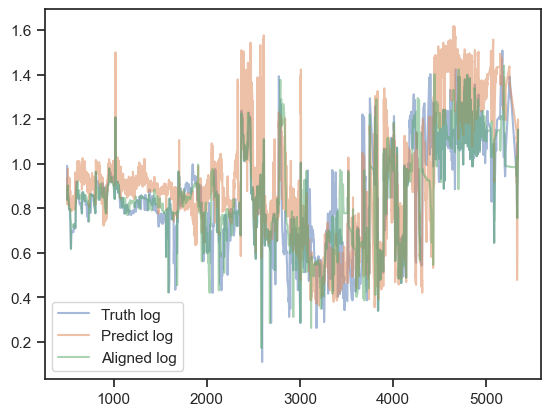

In [22]:

N=101
for well in list(dfs_val.keys()):
    for mykey in Y_feat:
        ref=dfs_val[well][f'{mykey}_pred'].values
        query=dfs_val[well][f'{mykey}_raw'].values

        ref_mean=np.convolve(ref, np.ones(N)/N, mode='same')
        query_mean=np.convolve(query, np.ones(N)/N, mode='same')

        ref2_mean=np.convolve((ref-ref_mean)**2, np.ones(N)/N, mode='same')
        query2_mean=np.convolve((query-query_mean)**2, np.ones(N)/N, mode='same')    

        ref_norm=(ref-ref_mean)/ref2_mean
        query_norm=(query-query_mean)/query2_mean


        query=(query-query.mean())/query.std()*ref.std()+ref.mean()
    #     loss_matrix=(query.reshape(1,-1)-ref.reshape(-1,1))**2
        alignmentOBE = dtw(query,ref,
                             step_pattern="asymmetric",# dist=lambda x, y: 10000000-x*y,
                             window_type="sakoechiba", window_size=201)
        mypath=alignmentOBE.get_warping_path(target="reference")
        dfs_val[well][f'{mykey}_dept_pred']=dfs_val[well]['DEPT'].values[mypath]
        
        f=interpolate.interp1d(dfs_val[well]['DEPT'].values[mypath]+0.0000001*np.arange(dfs_val[well]['DEPT'].values.size),dfs_val[well][f'{mykey}_raw'].values,
                               fill_value=(dfs_val[well][f'{mykey}_raw'].values[0], dfs_val[well][f'{mykey}_raw'].values[-1]), 
                               bounds_error=False,kind=1)
        dfs_val[well][f'{mykey}_val_pred']=f(dfs_val[well]['DEPT'].values)

        
        
        plt.figure()
        plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}'].values,alpha=0.5,label='Truth log')
        plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}_pred'].values,alpha=0.5,label='Predict log')
        plt.plot(dfs_val[well][f'{mykey}_dept_pred'].values,dfs_val[well][f'{mykey}_raw'].values,alpha=0.5,label='Aligned log')
#         plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}_val_pred'],alpha=0.5,label='Aligned log')
#         plt.plot(dfs_val[well]['DEPT'].values,dfs_val[well][f'{mykey}_val_pred'],alpha=0.5,label='Aligned log')
        plt.legend()
        plt.show()

### Evaluate the performance of this alignment algorithm

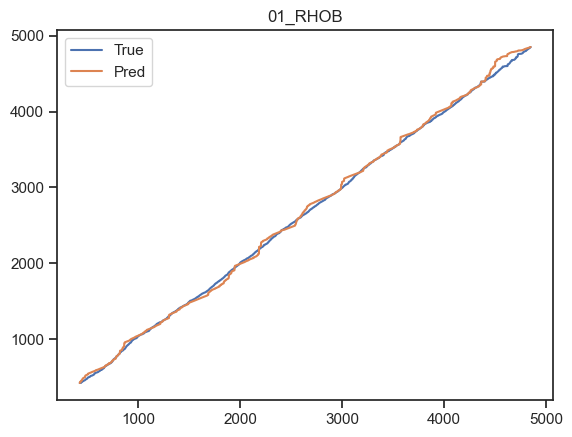

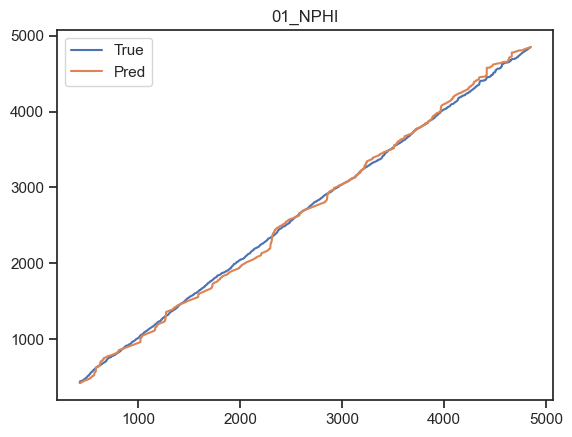

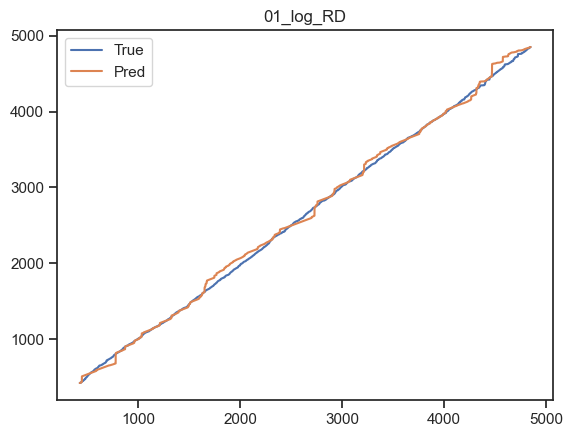

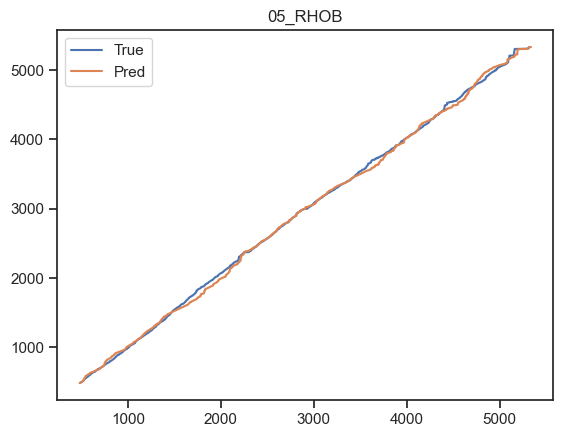

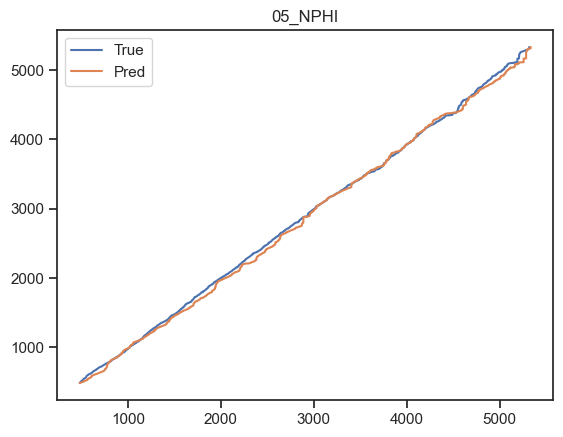

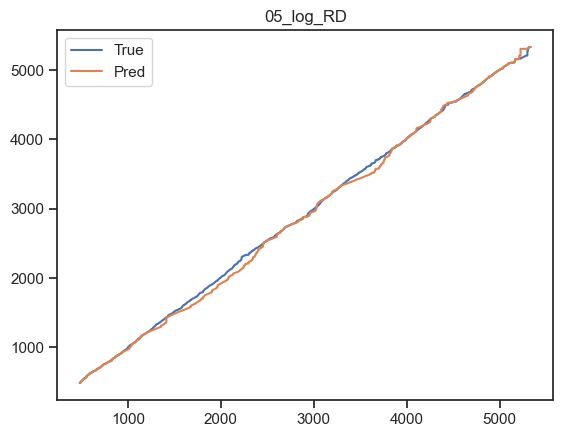

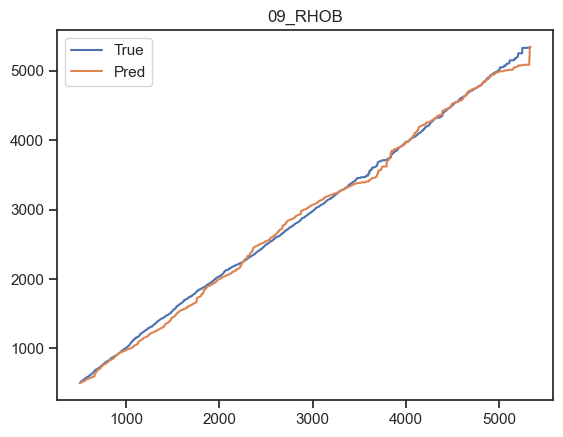

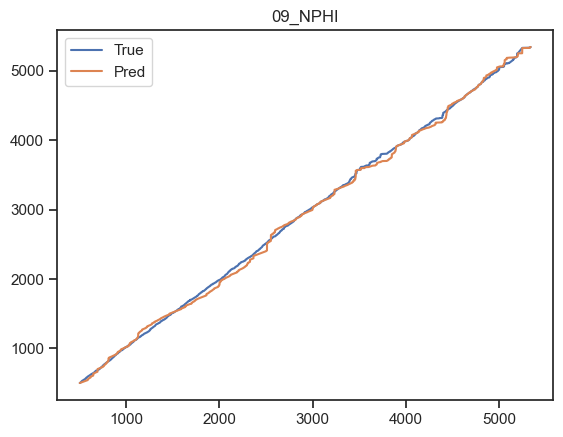

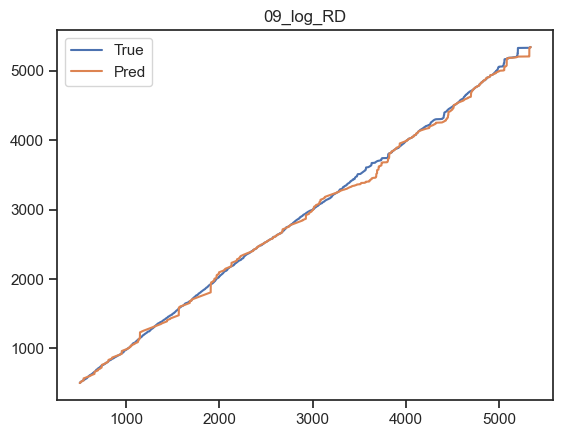

In [23]:
for well in list(dfs_val.keys()):
    for mykey in Y_feat:
        plt.figure()
        plt.plot(dfs_val[well][f'{mykey}_dept'].values,dfs_val[well]['DEPT'].values,label='True')
        plt.plot(dfs_val[well][f'{mykey}_dept_pred'],dfs_val[well]['DEPT'].values,label='Pred')
        plt.title(f'{well}_{mykey}')
        plt.legend()
        plt.show()


### Observations based on Validation
- The depth shifts based on perturbed truth well logs are good
- The depth shifts based on predicted well logs are not good
- Accurate estimate of values for misaligned well logs are important

### Calculate NMSE and MAD

In [24]:
score={}
score['nmse']={}
score['mad']={}
dfs_val_all=pd.concat([dfs_val[mykey] for mykey in dfs_val.keys()])


In [26]:
for mykey in Y_feat:
    score['nmse'][mykey]=(((dfs_val_all[f'{mykey}_val_pred'].values-dfs_val_all[f'{mykey}'].values)**2).mean())/(np.mean((dfs_val_all[f'{mykey}'].values)**2))
    score['mad'][mykey]=np.abs(dfs_val[well][f'{mykey}_dept'].values-dfs_val[well][f'{mykey}_dept_pred'].values).mean()

In [27]:
print(score)

{'nmse': {'RHOB': 0.0006176023361347086, 'NPHI': 0.02334501264132782, 'log_RD': 0.023681404487748147}, 'mad': {'RHOB': 58.597001385708765, 'NPHI': 36.31105397964214, 'log_RD': 32.97796239148875}}


## <a>8. Prediction</a>

In [28]:
def shift_log(dfs_val,log,N=1001):
    for well in range(len(dfs_val)):
        mykey=log
        ref=dfs_val[well][f'{mykey}_sft'].values
        query=dfs_val[well][f'{mykey}'].values

        ref_mean=np.convolve(ref, np.ones(N)/N, mode='same')
        query_mean=np.convolve(query, np.ones(N)/N, mode='same')

        ref2_mean=np.convolve((ref-ref_mean)**2, np.ones(N)/N, mode='same')
        query2_mean=np.convolve((query-query_mean)**2, np.ones(N)/N, mode='same')    

        ref_norm=(ref-ref_mean)/ref2_mean
        query_norm=(query-query_mean)/query2_mean


        query=(query-query.mean())/query.std()*ref.std()+ref.mean()
    #     loss_matrix=(query.reshape(1,-1)-ref.reshape(-1,1))**2
        alignmentOBE = dtw(query,ref,
                             step_pattern="asymmetric",# dist=lambda x, y: 10000000-x*y,
                             window_type="sakoechiba", window_size=301)
        mypath=alignmentOBE.get_warping_path(target="reference")
        dfs_val[well][f'{mykey}_dept_pred']=dfs_val[well]['DEPT'].values[mypath]

        f=interpolate.interp1d(dfs_val[well]['DEPT'].values[mypath]+0.0000001*np.arange(dfs_val[well]['DEPT'].values.size),dfs_val[well][f'{mykey}'].values,
                               fill_value=(dfs_val[well][f'{mykey}'].values[0], dfs_val[well][f'{mykey}'].values[-1]), 
                               bounds_error=False,kind=1)
        dfs_val[well][f'{mykey}_pred']=f(dfs_val[well]['DEPT'].values)
    return dfs_val

In [29]:
files=glob.glob('./data/test/*.csv')
df_test = []
for i in files:
    df0=pd.read_csv(i)
    df0['well']=i.split('align')[-1]
    df0['well']='align'+df0['well']
    df0['log_RD']=np.log10(df0['RD'])
    df_test.append(df0.copy())

In [30]:
for i in range(len(df_test)):
    df_test[i][f'{y_feat1[0]}_sft']=RF_best_1.predict(df_test[i][x_feat1].values)
df_test=shift_log(df_test,y_feat1[0])    

In [31]:
for i in range(len(df_test)):
    df_test[i][f'{y_feat2[0]}_sft']=RF_best_2.predict(df_test[i][x_feat2].values)
df_test=shift_log(df_test,y_feat2[0])   

In [32]:
for i in range(len(df_test)):
    df_test[i][f'{y_feat3[0]}_sft']=RF_best_3.predict(df_test[i][x_feat3].values)
df_test=shift_log(df_test,y_feat3[0])   

In [33]:
sub_path = './submission'
ref_features=['DEPT','GR']
pred_features=['NPHI','RHOB','RD']
val_pred=[i+'_pred' for i in pred_features]
dep_sft_pred=[i+'_dept_pred' for i in pred_features]
output_feat=ref_features+pred_features+val_pred+dep_sft_pred
if not os.path.isdir(sub_path):
    os.makedirs(sub_path)
for df in df_test:
    wellname=df.loc[0,'well']
    df['RD_pred']=10**df['log_RD_pred'].copy()
    df['RD_dept_pred']=df['log_RD_dept_pred'].copy()
    df[output_feat].to_csv(os.path.join(sub_path,wellname), index=False)

shutil.make_archive('./data/pdda_submission_1', 'zip', sub_path)
    

'D:\\Depth_Shift\\Well_Correlation\\Well_Correlation-main\\data\\pdda_submission_1.zip'

Save your predictions for each test well to a csv files, you are recommended to use the same csv file names as the test well file, and zip the files as {team_name}_submission_{n_sub}.zip, see below for example. Please replace `team_name` and `num_submit` with your own team name and the number of submission (see below example). In your submitted files files, your predictions should have the same number of rows as the input features (DEPT, GR, RHOB, NPHI, RD). Your predictions should be **corrected well logs (RHOB_pred,NPHI_pred,RD_pred)** and the depth shift (ft) of **raw well logs (RHOB_dept_pred, NPHI_dept_pred, RD_dept_pred)**. After make three csv files, please save and 

Each team can have up to 3 submissions per day. The best score among the 3 submissions will be ranked.

Please email us if you have any questions regarding submission (pdda_sig@spwla.org).
Submit your .zip file to Codalab.

- Zipped csv file {team_name}\_submission\_{n_sub}.zip should contain (aligned_well_01.csv, aligned_well_02.csv, and aligned_well_03.csv)

## <a>9. Discussion</a>

There are many things worth further exploration. We list several of them here:
1. Select the most relevant features.
2. Handle the missing values in better ways.
3. Determine anomalous data points in better approaches.
4. Zonate the logs and train different models for different zones.
5. K-fold cross validate the model.
6. Apply more sophisticated models.

## <a>10. Summary</a>

In this tutorial, we demonstrate the machine-learning workflow on a practical petrophysical problem: preparing a data set, training and testing a regression model and a signal-alignment model, and finally, testing the model on the unseen data. Libraries and open-source tools, such as scikit-learn provide powerful algorithms that can be applied to problems with a few lines of code, which greatly helps to facilitate the research of data science in the petrophysics area. In addition to the procedures mentioned above, many other methods may be applied to improve the performance and stability of the model, such as applying better treatments to the anomalies, train different models for zones with different lithologies, training other regression models, try reinforcement learning, try crosscorrelation-based epth shift method, and combination of them.

## References
Yu, Y., Xu, C., Misra, S., Li, W., Ashby, M., Pan, W., Deng, T., Jo, H., Santos, J.E., Fu, L. and Wang, C., 2021, Synthetic Sonic Log Generation With Machine Learning: A Contest Summary From Five Methods, Petrophysics, 62(4), 393–406.